<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#NB-description" data-toc-modified-id="NB-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>NB description</a></span></li><li><span><a href="#The-dotsPositions.csv-data" data-toc-modified-id="The-dotsPositions.csv-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The dotsPositions.csv data</a></span></li><li><span><a href="#Write-a-dotsDB-HDF5-file" data-toc-modified-id="Write-a-dotsDB-HDF5-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Write a dotsDB HDF5 file</a></span><ul class="toc-item"><li><span><a href="#Write-HDF5-file" data-toc-modified-id="Write-HDF5-file-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Write HDF5 file</a></span></li></ul></li><li><span><a href="#Diagnostic" data-toc-modified-id="Diagnostic-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Diagnostic</a></span></li></ul></div>

# NB description
date: 10 Dec 2019  
This notebook contains code that:
- builds an HDF5 dotsDB database off of dotsPositions.csv files from the Fall 2019 data (subjects 10-13)

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import seaborn as sns
import h5py     
import os.path

# add location of custom modules to path
sys.path.insert(0,'../modules/')
sys.path.insert(0,'../modules/dots_db/dotsDB/')

# custom modules
import dotsDB as ddb
import motionenergy as kiani_me
import stimulus as stim
import ME_functions as my_me

# The dotsPositions.csv data
With the current pipeline, on the day of the session, a `.csv` file is written to disk with the FIRA data. Then, in the `motion_energy_Adrian` repo, I have MATLAB functions `reproduce_dots` and `batch_reproduce_dots` that write `_dotsPositions.csv` files to disk (one file per session).

The first step here is to loop through the completed sessions, perform a `join` of the dots and fira data, and update a global `.csv` file, as well as session-specific `.csv` files, called `labeled_dots_<timestamp>.csv`.

In [2]:
!find /home/adrian/SingleCP_DotsReversal/Fall2019/raw -name "*dotsPositions.csv" -print

/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_06_12_43/2019_11_06_12_43_dotsPositions.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_26_13_11/2019_11_26_13_11_dotsPositions.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_05_16_19/2019_11_05_16_19_dotsPositions.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_20_15_34/2019_11_20_15_34_dotsPositions.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_05_10_27/2019_11_05_10_27_dotsPositions.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_19_13_15/2019_11_19_13_15_dotsPositions.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_05_13_18/2019_11_05_13_18_dotsPositions.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_25_16_12/2019_11_25_16_12_dotsPositions.csv


In [3]:
!find /home/adrian/SingleCP_DotsReversal/Fall2019/raw -name "completed*100*.csv" -print

/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_06_12_43/completed4AFCtrials_task100_date_2019_11_06_12_43.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_26_13_11/completed4AFCtrials_task100_date_2019_11_26_13_11.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_05_16_19/completed4AFCtrials_task100_date_2019_11_05_16_19.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_20_15_34/completed4AFCtrials_task100_date_2019_11_20_15_34.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_05_10_27/completed4AFCtrials_task100_date_2019_11_05_10_27.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_19_13_15/completed4AFCtrials_task100_date_2019_11_19_13_15.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_05_13_18/completed4AFCtrials_task100_date_2019_11_05_13_18.csv
/home/adrian/SingleCP_DotsReversal/Fall2019/raw/2019_11_25_16_12/completed4AFCtrials_task100_date_2019_11_25_16_12.csv


In [4]:
def label_dots(timestamps, global_labeled_dots_filename, data_folder):
    """
    fetches dots data outputted by MATLAB (the _dotsPositions.csv files) for specified session timestamps, adds
    relevant fira data (join operation) and appends resulting 'labeled_dots' dataframe to the 
    global_labeled_dots_filename.
    :param timestamps: list or tuple of strings of the form '2019_11_05_16_19'
    :param global_labeled_dots_filename: string with full path and filename for global .csv file to write to
    :param data_folder: string with path to folder '.../raw/' where fira and dotsPositions .csv data reside.
    :return: None, but writes to file
    """
    list_of_labeled_dots_dataframes = []
    for ts in timestamps:
        folder = data_folder + ts + '/'
        fira = pd.read_csv(folder + 'completed4AFCtrials_task100_date_' + ts + '.csv')
        dots = pd.read_csv(folder + ts + '_dotsPositions.csv')
        dots = dots[dots['isActive'] == 1]
        del dots['isActive'], dots['taskID'], dots['isCoherent']
        try:
            assert fira.index.min() == 0 and fira.index.max() == 819 and len(fira.index) == 820
            assert dots['trialIx'].min() == 0 and dots['trialIx'].max() == 819
        except AssertionError:
            print(f'assert failed with timestamp {ts}')
            continue
        labeled_dots = dots.join(fira, on="trialIx")
        labeled_dots['trueVD'] = labeled_dots['dotsOff'] - labeled_dots['dotsOn']
        labeled_dots['presenceCP'] = labeled_dots['reversal'] > 0
        to_drop = ['trialIndex', 'RT', 'cpRT', 'dirCorrect', 'cpCorrect', 
            'randSeedBase', 'fixationOn', 'fixationStart', 'targetOn',
            'choiceTime', 'cpChoiceTime', 'blankScreen', 'feedbackOn', 
            'cpScreenOn', 'dummyBlank', 'finalDuration', 'dotsOn', 'dotsOff']
        labeled_dots.drop(columns=to_drop, inplace=True)
        to_rename = {
            'duration': 'viewingDuration',
            'direction': 'initDirection',
        }
        labeled_dots.rename(columns=to_rename, inplace=True)
        labeled_dots.dropna(subset=['dirChoice'], inplace=True)
        list_of_labeled_dots_dataframes.append(labeled_dots)
        
    # only write to file if list of dataframes is not empty
    if list_of_labeled_dots_dataframes:
        full_labeled_dots = pd.concat(list_of_labeled_dots_dataframes)
        if os.path.exists(global_labeled_dots_filename):
            full_labeled_dots.to_csv(global_labeled_dots_filename, index=False, mode='a+', header=False)
        else:
            full_labeled_dots.to_csv(global_labeled_dots_filename, index=False, mode='a+', header=True)
            
    return None

In [5]:
'''
list of written data timestamps:
'2019_11_06_12_43'
'2019_11_05_16_19',
'2019_11_20_15_34',
'2019_11_19_13_15',
'2019_11_05_13_18',
'2019_11_26_13_11',
'2019_11_25_16_12',

list of problematic timestamps that were NOT written
'2019_11_05_10_27'  (subject=10 probCP=0.3)
'''
TIMESTAMPS = ()

In [6]:
DATA_FOLDER = '/home/adrian/SingleCP_DotsReversal/Fall2019/raw/'

The fira dataframe has index ranging from 0 to 819. The next step is to create a "foreign key" to this index into the dots dataframe.

In [7]:
DOTS_LABELED = '/home/adrian/SingleCP_DotsReversal/Fall2019/processed/dots_fall_2019_v1.csv'

In [8]:
label_dots(TIMESTAMPS, DOTS_LABELED, DATA_FOLDER)

In [9]:
def inspect_csv(df):
    """df is a pandas.DataFrame"""
    print(df.head())
    print(len(df))
    print(np.unique(df['taskID']))
    try:
        print(np.unique(df['pilotID']))
    except KeyError:
        print(np.unique(df['subject']))

# Write a dotsDB HDF5 file
Now that all the dotsPositions.csv data is collected into a single global .csv file, I wish to dump it all into an hdf5 database.

Several actions need to be implemented.
1. For each trial in the dotsPositions.csv data, I need to know: _coherence_, _viewing duration_, _presenceCP_, _direction_, _subject_, _block_ (_probCP_). For this, I will assume that the `trialEnd` (from FIRA) and `seqDumpTime` (from dotsPositions) timestamps are in the same unit.
2. I need to decide how to organize my dotsDB hierarchically. Example is `subj15/probCP0.1/coh0/ansleft/CPno/VD100`

In [10]:
def get_trial_params(df):
    """coherence, viewing duration, presenceCP, direction, subject, block, probCP"""
    coh = df['coherence'].values[0]
    vd = df['viewingDuration'].values[0]
    pcp = df['presenceCP'].values[0]
    idir = df['initDirection'].values[0]
    subj = df['subject'].values[0]
    block = df['block'].values[0]
    Pcp = df['probCP'].values[0]
    return coh, vd, pcp, idir, subj, block, Pcp

In [11]:
def get_trial_from_dots_ts(dot_ts, trials_ts, trials_df):
    trial_dump_time = np.min(trials_ts[trials_ts>dot_ts])
    assert trial_dump_time - dot_ts < .5, 'trialEnd occurs more than 0.5 sec after seqDumpTime'
    return trials_df[trials_df['trialEnd'] == trial_dump_time]

In [12]:
def add_trial_params(row, t, trials):
    """
    function that adds appropriate values to trial parameter columns in dots dataframe
    :param row: row from dataframe
    :param t: dataframe with FIRA data
    :param trials: numpy array of trialEnd timestamps (scalars)
    """
    time = row['seqDumpTime']
    try:
        trial = get_trial_from_dots_ts(time, trials, t)
    except AssertionError:
        print(f'0.5 sec margin failed at row {row.name}')
        return row
    c,v,p,i,s,b,P = get_trial_params(trial)
    row['coherence'] = c
    row['viewingDuration'] = v
    row['presenceCP'] = p
    row['initDirection'] = i
    row['subject'] = s
    row['block'] = b
    row['probCP'] = P
    return row

def set_nans(df):
    if 'isActive' in df:
        del df['isActive']
    df['coherence'] = np.nan
    df['viewingDuration'] = np.nan
    df['presenceCP'] = np.nan
    df['initDirection'] = np.nan
    df['subject'] = np.nan
    df['block'] = np.nan
    df['probCP'] = np.nan
    return df

So far so good, for a given `seqDumpTime` value, I am able to recover the trial's parameters. All that remains to do is to add columns to the dots dataframe (and remove the `isActive` one).

**Following cell is SLOW! Around 30 min**

I forgot to record true duration and subject's choice!
Rebelote...

I should have added `dirChoice` instead of `cpChoice`!!!

Now, it turns out some rows have a `nan` value in the `dirChoice` column!
I will drop them!

## Write HDF5 file
Now, I need to write an HDF5 file with the structure:
`subj15/probCP0.1/coh0/ansleft/CPno/VD100`.

I need to:
- loop through the trials contained in the dots DF
- port the dots data to dotsDB format
- write to file

In [13]:
dots = pd.read_csv(DOTS_LABELED)

In [14]:
dots.head()

,xpos,ypos,frameIdx,trialIx,taskID,trialStart,trialEnd,dirChoice,cpChoice,initDirection,coherence,finalCPTime,subject,date,probCP,reversal,viewingDuration,trueVD,presenceCP
0,0.915860,0.251297,1,0,100,2.215517e+06,2.215519e+06,0,0,180,18,NaN,11,201911061243,0.7,0.0,0.4,0.424559,False
1,0.283857,0.940118,1,0,100,2.215517e+06,2.215519e+06,0,0,180,18,NaN,11,201911061243,0.7,0.0,0.4,0.424559,False
2,0.961799,0.232799,1,0,100,2.215517e+06,2.215519e+06,0,0,180,18,NaN,11,201911061243,0.7,0.0,0.4,0.424559,False
3,0.961470,0.362006,1,0,100,2.215517e+06,2.215519e+06,0,0,180,18,NaN,11,201911061243,0.7,0.0,0.4,0.424559,False
4,0.559943,0.692933,1,0,100,2.215517e+06,2.215519e+06,0,0,180,18,NaN,11,201911061243,0.7,0.0,0.4,0.424559,False


In [15]:
dots.shape

(7138854, 19)

In [16]:
dots.columns

Index(['xpos', 'ypos', 'frameIdx', 'trialIx', 'taskID', 'trialStart',
       'trialEnd', 'dirChoice', 'cpChoice', 'initDirection', 'coherence',
       'finalCPTime', 'subject', 'date', 'probCP', 'reversal',
       'viewingDuration', 'trueVD', 'presenceCP'],
      dtype='object')

In [17]:
gb = dots.groupby('trialEnd')  # recall gb.get_group() and gb['frameIdx'].max()

At this stage, I would like to know the max value of `frameIdx` in each trial.

In [18]:
# Needs to be re-written
def get_frames(df):
    """
    get the dots data as a list of numpy arrays, as dotsDB requires them
    """
    # (could/should probably be re-written with groupby and apply...)
    num_frames = np.max(df["frameIdx"]).astype(int)
    assert not np.isnan(num_frames), 'NaN num_frames'
    list_of_frames = []
    for fr in range(num_frames):
        frame_data = df[df["frameIdx"] == (fr+1)]
        list_of_frames.append(np.array(frame_data[['ypos','xpos']]))  # here I swap xpos with ypos for dotsDB
    return list_of_frames

def get_group_name(df):
    """
    get the trial's parameters, and therefore the HDF5 group where the data should be appended
    """       
    # get HDF5 group name
    
    def choice(c):
        """
        :param c: (int) either 0 for 'left' or 1 for 'right'
        :return: (str) either '/ansright' or '/ansleft'
        """
        if c == 1:
            return '/ansright' 
        elif c == 0:
            return '/ansleft'
        else:
            raise ValueError(f'unexpected choice value {c}')
            
    def chgepoint(c):
        """
        :param c: (bool) whether the trial contains a CP or not
        :return: (str) either '/CPyes' or '/CPno'
        """
        return '/CPyes' if c else '/CPno'
    
    def viewdur(v):
        """
        :param v: (float or int) viewing duration in seconds
        :return: (str) e.g. '/VD200'
        """
        return '/VD' + str(int(1000*v))
    
    def direction(d):
        """
        :param d: (int) either 180 for left or 0 for rightward moving dots (at start of trial)
        :return: (str) either 'left' or 'right'
        """
        return 'left' if d else 'right'
    
    ss, pp, cc, ch, cp, vd, di, cpt= df[['subject', 'probCP', 'coherence', 'dirChoice', 'presenceCP', 
                               'viewingDuration', 'initDirection', 'finalCPTime']].values[0,:]
    
    ss = str(ss)
    group_name = '/subj' + ss + \
                 '/probCP' + str(pp) + \
                 '/coh' + str(cc) + \
                 choice(ch) + \
                 chgepoint(cp) + \
                 viewdur(vd) + '/' + \
                 direction(di)
                 
    vals = {'coh': cc, 
            'subject': ss,  # should ss be int or str here???
            'probCP': pp, 
            'dirChoice': ch,
            'presenceCP': cp,
            'viewingDuration': vd, 
            'initDirection': direction(di),
            'cpTime': cpt}
    
    return group_name, vals

def write_dots_to_file(df, hdf5_file):
    """
    The aim of this function is to write the dots info contained in the pandas.DataFrame df to a dotsDB HDF5 file.
    df should only contain data about a single trial. 
    
    head on df looks like this
    xpos	ypos	isCoherent	frameIdx	seqDumpTime	pilotID	taskID	coherence	viewingDuration	presenceCP	initDirection	subject	block	probCP	cpChoice	trueVD	trialEnd	dirChoice
	0.722093	0.416122	1.0	1.0	1069.27719	2.0	3.0	48.5	0.3	0.0	180.0	S1	Block2	0.0	NaN	0.318517	1069.535562	0.0
	0.681785	0.356234	1.0	1.0	1069.27719	2.0	3.0	48.5	0.3	0.0	180.0	S1	Block2	0.0	NaN	0.318517	1069.535562	0.0
	0.445828	0.914470	1.0	1.0	1069.27719	2.0	3.0	48.5	0.3	0.0	180.0	S1	Block2	0.0	NaN	0.318517	1069.535562	0.0
	0.833181	0.112126	1.0	1.0	1069.27719	2.0	3.0	48.5	0.3	0.0	180.0	S1	Block2	0.0	NaN	0.318517	1069.535562	0.0
	0.013516	0.354543	1.0	1.0	1069.27719	2.0	3.0	48.5	0.3	0.0	180.0	S1	Block2	0.0	NaN	0.318517	1069.535562	0.0
    """
    frames = get_frames(df)
    gn, params = get_group_name(df)
    
    # exit function if number of frames too different from theoretical one 
    vd = params['viewingDuration']
    num_frames = len(frames)
    if abs(num_frames-vd*60) > 5:
        tr = df['trialEnd'].values[0]
        print(f'trial with trialEnd {tr} not written; discrepancy num_frames {num_frames} and VD {vd}')
        return None
    
    cptime = params['cpTime'] if params['presenceCP'] else None
    parameters = dict(speed=5, 
                      density=90, 
                      coh_mean=params['coh'], 
                      coh_stdev=10, 
                      direction=params['initDirection'],
                      num_frames=np.max(df["frameIdx"]).astype(int),
                      diameter=5, 
                      pixels_per_degree=(55.4612 / 2), 
                      dot_size_in_pxs=3, 
                      cp_time=cptime)
    
    stimulus = ddb.DotsStimulus(**parameters)
    
    try:
        ddb.write_stimulus_to_file(stimulus, 1, hdf5_file, 
                                   pre_generated_stimulus=[frames],
                                   group_name=gn, append_to_group=True, max_trials=50)
    except TypeError:
        print(f'group name {gn}')
        print(f'type(frames) = {type(frames)}, len(frames)= {len(frames)}, frames[0].shape = {frames[0].shape}')
        raise

In [19]:
# # get the first two seqDumpTime values for toy example
# counter = 0
# for ix in gb.groups.keys():
#     counter += 1
#     if counter == 6:
#         break
#     write_dots_to_file(dots[dots['seqDumpTime']==ix], 'test_pilot.h5')

Following cell takes a bit under 9 min

In [20]:
# Recall func is called twice the first time!
if False:  # just a failsafe not to run this cell by mistake
    _ = gb.apply(write_dots_to_file, 'fall2019_v1.h5')

# ??? need to go in manually and delete the first entry in the dataset corresponding to 
# the first group element gb.groups.keys()[0] ???

In [21]:
tend = list(gb.groups.keys())[0]
fira = pd.read_csv(DATA_FOLDER + 'full_2019_12_02.csv')
fira.head()

,taskID,trialIndex,trialStart,trialEnd,RT,cpRT,dirChoice,cpChoice,dirCorrect,cpCorrect,...,blankScreen,feedbackOn,subject,date,probCP,cpScreenOn,dummyBlank,reversal,duration,finalDuration
0,100,1,2.131056e+06,2.131063e+06,0.213185,2.864000,0,0,1,1,...,2.131063e+06,NaN,10,201911051318,0.7,3.290608,6.155014,0.0,0.40,NaN
1,100,2,2.131064e+06,2.131066e+06,0.458183,0.815998,1,0,0,0,...,2.131066e+06,NaN,10,201911051318,0.7,1.761605,2.575164,0.2,0.25,NaN
2,100,3,2.131067e+06,2.131070e+06,0.413732,0.735999,1,0,1,1,...,2.131070e+06,NaN,10,201911051318,0.7,1.412050,2.140863,0.0,0.20,NaN
3,100,4,2.131071e+06,2.131074e+06,0.357103,1.112000,1,0,0,1,...,2.131074e+06,NaN,10,201911051318,0.7,1.975471,3.077166,0.0,0.40,NaN
4,100,5,2.131075e+06,2.131077e+06,0.494251,0.567998,1,0,0,0,...,2.131077e+06,NaN,10,201911051318,0.7,1.485211,2.044533,0.2,0.25,NaN


In [56]:
fira['direction'].unique()

array([180,   0])

In [57]:
fira['dirChoice'].unique()

array([0, 1])

In [74]:
fira[fira['trialEnd'] == tend][['subject', 'dirChoice', 'duration', 'probCP', 'direction', 'coherence', 'reversal']]

,subject,dirChoice,duration,probCP,direction,coherence,reversal
3255,12,1,0.3,0.3,0,27,0.0


In [23]:
fira.dtypes

taskID             int64
trialIndex         int64
trialStart       float64
trialEnd         float64
RT               float64
cpRT             float64
dirChoice          int64
cpChoice           int64
dirCorrect         int64
cpCorrect          int64
direction          int64
coherence          int64
randSeedBase       int64
fixationOn       float64
fixationStart    float64
targetOn         float64
dotsOn           float64
finalCPTime      float64
dotsOff          float64
choiceTime       float64
cpChoiceTime     float64
blankScreen      float64
feedbackOn       float64
subject            int64
date               int64
probCP           float64
cpScreenOn       float64
dummyBlank       float64
reversal         float64
duration         float64
finalDuration    float64
dtype: object

In [84]:
fira[
    (fira['subject'] == 10) & 
    (fira['probCP'] == 0.7) & 
    (fira['coherence'] == 61) & 
    (fira['dirChoice'] == 1) & 
    (fira['reversal'] == 0.2) & 
    (fira['duration'] == .4) & 
    (fira['direction'] == 0)
]

,taskID,trialIndex,trialStart,trialEnd,RT,cpRT,dirChoice,cpChoice,dirCorrect,cpCorrect,...,blankScreen,feedbackOn,subject,date,probCP,cpScreenOn,dummyBlank,reversal,duration,finalDuration
6,100,7,2.131082e+06,2.131087e+06,1.740851,1.192012,1,1,1,1,...,2.131087e+06,NaN,10,201911051318,0.7,3.331376,4.534766,0.2,0.4,NaN
35,100,36,2.131239e+06,2.131241e+06,0.366789,0.584001,1,1,1,1,...,2.131241e+06,NaN,10,201911051318,0.7,1.536615,2.129835,0.2,0.4,NaN
40,100,41,2.131257e+06,2.131262e+06,1.910201,0.800011,1,1,1,1,...,2.131262e+06,NaN,10,201911051318,0.7,3.370756,4.184315,0.2,0.4,NaN
43,100,44,2.131270e+06,2.131274e+06,1.003750,1.144003,1,1,1,1,...,2.131274e+06,NaN,10,201911051318,0.7,2.400286,3.535879,0.2,0.4,NaN
61,100,62,2.131346e+06,2.131349e+06,1.490744,0.464007,1,1,1,1,...,2.131349e+06,NaN,10,201911051318,0.7,2.631566,3.089193,0.2,0.4,NaN
102,100,103,2.131562e+06,2.131567e+06,1.958442,0.744000,1,1,1,1,...,2.131567e+06,NaN,10,201911051318,0.7,3.524186,4.269948,0.2,0.4,NaN
107,100,108,2.131585e+06,2.131589e+06,1.146074,0.544003,1,1,1,1,...,2.131589e+06,NaN,10,201911051318,0.7,2.944104,3.486477,0.2,0.4,NaN
108,100,109,2.131590e+06,2.131594e+06,2.059825,0.599994,1,1,1,1,...,2.131594e+06,NaN,10,201911051318,0.7,3.411241,4.021410,0.2,0.4,NaN
151,100,152,2.131853e+06,2.131856e+06,0.773634,0.712001,1,1,1,1,...,2.131856e+06,NaN,10,201911051318,0.7,2.229001,2.940865,0.2,0.4,NaN
176,100,177,2.131979e+06,2.131981e+06,0.388357,0.639998,1,1,1,1,...,2.131981e+06,NaN,10,201911051318,0.7,1.700736,2.327854,0.2,0.4,NaN


In [83]:
print(pb_dset_name[1:])
print(count_trials_fira(pb_dset_name[1:], fira))

subj10/probCP0.7/coh61/ansright/CPyes/VD400/right/px
53


The fact that only 4 trials correspond to the dataset for which the HDF5 length was doubled during the dump procedure is worrying.

In [25]:
particular_dset = dots[
    (dots['subject'] == 10) & (dots['probCP'] == 0.7) & (dots['coherence'] == 61) \
    & (dots['dirChoice'] == 0) & (dots['reversal'] == 0.2) & (dots['viewingDuration'] == .4) & \
    (dots['initDirection'] == 0)
]

In [26]:
particular_dset.head()

,xpos,ypos,frameIdx,trialIx,taskID,trialStart,trialEnd,dirChoice,cpChoice,initDirection,coherence,finalCPTime,subject,date,probCP,reversal,viewingDuration,trueVD,presenceCP
4088430,0.440584,0.165984,1,11,100,2.131138e+06,2.131140e+06,0,1,0,61,0.249637,10,201911051318,0.7,0.2,0.4,0.416521,True
4088431,0.633295,0.807146,1,11,100,2.131138e+06,2.131140e+06,0,1,0,61,0.249637,10,201911051318,0.7,0.2,0.4,0.416521,True
4088432,0.156161,0.954171,1,11,100,2.131138e+06,2.131140e+06,0,1,0,61,0.249637,10,201911051318,0.7,0.2,0.4,0.416521,True
4088433,0.830146,0.749911,1,11,100,2.131138e+06,2.131140e+06,0,1,0,61,0.249637,10,201911051318,0.7,0.2,0.4,0.416521,True
4088434,0.235568,0.201645,1,11,100,2.131138e+06,2.131140e+06,0,1,0,61,0.249637,10,201911051318,0.7,0.2,0.4,0.416521,True


In [27]:
particular_dset.shape

(6598, 19)

In [28]:
particular_dset['trialIx'].unique()

array([ 11,  53, 145, 530])

# Diagnostic

In [29]:
import h5py
import numpy as np

In [30]:
pb_dset_name = '/subj10/probCP0.7/coh61/ansright/CPyes/VD400/right/px'

In [31]:
h5_filename = '/home/adrian/SingleCP_DotsReversal/Fall2019/processed/fall2019_v1.h5'

In [32]:
f = h5py.File(h5_filename, 'r')

In [33]:
d = f[pb_dset_name]

In [35]:
not(any([len(dd) for dd in d[-47:]]))

True

In [36]:
first_fifty_three = [len(dd) for dd in d[:53]]
all(first_fifty_three)

True

In [37]:
print('min ', min(first_fifty_three), ' max ', max(first_fifty_three))

min  554496  max  600704


In [38]:
a=f[pb_dset_name[:-3]]

In [39]:
(a.attrs['frame_width_in_pxs'] ** 2) * round(.4 * 60)

554496

In [40]:
(a.attrs['frame_width_in_pxs'] ** 2) * round(.437 * 60)

600704

The last 47 items in the problematic dataset are empty and the first 53 are not. Each trial has a number of frames corresponding to some duration between 400 and 437 msec.

In [41]:
def count_duplicates(dataset):
    """   
    goes through all elements in dataset and builds two objects:
    :param dataset: an h5py dataset instance. Its shape is assumed to be of the 
        form (N,) and each entry is an ndarray of bools.
    :returns: a dict 'seen' and a list 'dupes'. The dict has as keys 
        the unique elements from the dataset and as values their counts.
        The list has unique duplicated elements
    """
    seen = {}
    dupes = []

    for x in dataset:
        x = tuple(x)
        if x not in seen:
            seen[x] = 1
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    return seen, dupes

It appears that 2 out of the three unique trials in the dataset (one of them is trivially 0) were duplicated between 16 and 34 times!

Did this happen with other datasets?

In [45]:
# This cell takes 1 or 2 min to run with subjects 10-13
dsets = {}
def count_meta(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name)
        dsets[name] = count_duplicates(obj)
    return None
f.visititems(count_meta)    

subj10/probCP0.7/coh0/ansleft/CPno/VD100/left/px
subj10/probCP0.7/coh0/ansleft/CPno/VD100/right/px
subj10/probCP0.7/coh0/ansleft/CPno/VD200/left/px
subj10/probCP0.7/coh0/ansleft/CPno/VD200/right/px
subj10/probCP0.7/coh0/ansleft/CPno/VD250/left/px
subj10/probCP0.7/coh0/ansleft/CPno/VD250/right/px
subj10/probCP0.7/coh0/ansleft/CPno/VD300/right/px
subj10/probCP0.7/coh0/ansleft/CPno/VD400/left/px
subj10/probCP0.7/coh0/ansleft/CPno/VD400/right/px
subj10/probCP0.7/coh0/ansleft/CPyes/VD250/left/px
subj10/probCP0.7/coh0/ansleft/CPyes/VD250/right/px
subj10/probCP0.7/coh0/ansleft/CPyes/VD300/left/px
subj10/probCP0.7/coh0/ansleft/CPyes/VD300/right/px
subj10/probCP0.7/coh0/ansleft/CPyes/VD400/left/px
subj10/probCP0.7/coh0/ansleft/CPyes/VD400/right/px
subj10/probCP0.7/coh0/ansleft/CPyes/VD600/left/px
subj10/probCP0.7/coh0/ansleft/CPyes/VD600/right/px
subj10/probCP0.7/coh0/ansright/CPno/VD100/left/px
subj10/probCP0.7/coh0/ansright/CPno/VD100/right/px
subj10/probCP0.7/coh0/ansright/CPno/VD200/left/px

subj11/probCP0.3/coh22/ansleft/CPyes/VD600/left/px
subj11/probCP0.3/coh22/ansleft/CPyes/VD600/right/px
subj11/probCP0.3/coh22/ansright/CPno/VD100/left/px
subj11/probCP0.3/coh22/ansright/CPno/VD100/right/px
subj11/probCP0.3/coh22/ansright/CPno/VD200/left/px
subj11/probCP0.3/coh22/ansright/CPno/VD200/right/px
subj11/probCP0.3/coh22/ansright/CPno/VD250/left/px
subj11/probCP0.3/coh22/ansright/CPno/VD250/right/px
subj11/probCP0.3/coh22/ansright/CPno/VD300/left/px
subj11/probCP0.3/coh22/ansright/CPno/VD300/right/px
subj11/probCP0.3/coh22/ansright/CPno/VD400/left/px
subj11/probCP0.3/coh22/ansright/CPno/VD400/right/px
subj11/probCP0.3/coh22/ansright/CPno/VD600/left/px
subj11/probCP0.3/coh22/ansright/CPno/VD600/right/px
subj11/probCP0.3/coh22/ansright/CPyes/VD250/left/px
subj11/probCP0.3/coh22/ansright/CPyes/VD250/right/px
subj11/probCP0.3/coh22/ansright/CPyes/VD300/left/px
subj11/probCP0.3/coh22/ansright/CPyes/VD300/right/px
subj11/probCP0.3/coh22/ansright/CPyes/VD400/left/px
subj11/probCP0.3/

subj12/probCP0.3/coh27/ansleft/CPno/VD100/left/px
subj12/probCP0.3/coh27/ansleft/CPno/VD100/right/px
subj12/probCP0.3/coh27/ansleft/CPno/VD200/left/px
subj12/probCP0.3/coh27/ansleft/CPno/VD200/right/px
subj12/probCP0.3/coh27/ansleft/CPno/VD250/left/px
subj12/probCP0.3/coh27/ansleft/CPno/VD250/right/px
subj12/probCP0.3/coh27/ansleft/CPno/VD300/left/px
subj12/probCP0.3/coh27/ansleft/CPno/VD300/right/px
subj12/probCP0.3/coh27/ansleft/CPno/VD400/left/px
subj12/probCP0.3/coh27/ansleft/CPno/VD400/right/px
subj12/probCP0.3/coh27/ansleft/CPno/VD600/left/px
subj12/probCP0.3/coh27/ansleft/CPno/VD600/right/px
subj12/probCP0.3/coh27/ansleft/CPyes/VD250/left/px
subj12/probCP0.3/coh27/ansleft/CPyes/VD250/right/px
subj12/probCP0.3/coh27/ansleft/CPyes/VD300/left/px
subj12/probCP0.3/coh27/ansleft/CPyes/VD300/right/px
subj12/probCP0.3/coh27/ansleft/CPyes/VD400/left/px
subj12/probCP0.3/coh27/ansleft/CPyes/VD400/right/px
subj12/probCP0.3/coh27/ansleft/CPyes/VD600/left/px
subj12/probCP0.3/coh27/ansright/CP

subj13/probCP0.3/coh100/ansleft/CPno/VD300/left/px
subj13/probCP0.3/coh100/ansleft/CPno/VD400/left/px
subj13/probCP0.3/coh100/ansleft/CPyes/VD250/left/px
subj13/probCP0.3/coh100/ansleft/CPyes/VD300/left/px
subj13/probCP0.3/coh100/ansleft/CPyes/VD400/left/px
subj13/probCP0.3/coh100/ansright/CPno/VD100/right/px
subj13/probCP0.3/coh100/ansright/CPno/VD200/right/px
subj13/probCP0.3/coh100/ansright/CPno/VD250/right/px
subj13/probCP0.3/coh100/ansright/CPno/VD400/right/px
subj13/probCP0.3/coh100/ansright/CPno/VD600/right/px
subj13/probCP0.3/coh100/ansright/CPyes/VD400/right/px
subj13/probCP0.3/coh49/ansleft/CPno/VD100/left/px
subj13/probCP0.3/coh49/ansleft/CPno/VD100/right/px
subj13/probCP0.3/coh49/ansleft/CPno/VD200/left/px
subj13/probCP0.3/coh49/ansleft/CPno/VD200/right/px
subj13/probCP0.3/coh49/ansleft/CPno/VD250/left/px
subj13/probCP0.3/coh49/ansleft/CPno/VD250/right/px
subj13/probCP0.3/coh49/ansleft/CPno/VD300/left/px
subj13/probCP0.3/coh49/ansleft/CPno/VD300/right/px
subj13/probCP0.3/co

In [46]:
len(dsets)

622

In [47]:
dupes_exist = 0
num_dupes = []
min_repeat, max_repeat = [], []
for stats in dsets.values():
    if stats[1]:
        dupes_exist += 1
        min_repeat.append(min([v for v in stats[0].values() if v > 1]))
        max_repeat.append(max([v for v in stats[0].values() if v > 1]))
        num_dupes.append(len(stats[1]))
print(f'dupes exist in {dupes_exist} out of {len(dsets)} datasets')

dupes exist in 622 out of 622 datasets


In [48]:
print(min(num_dupes), max(num_dupes))

1 5


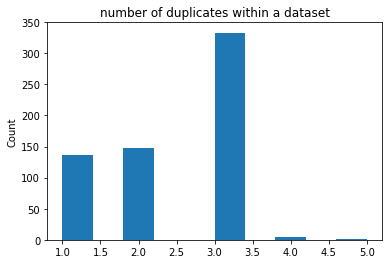

In [49]:
plt.hist(num_dupes);
plt.title('number of duplicates within a dataset');
plt.ylabel('Count');

It appears duplicates exist in several hundreds datasets. This is worrying :(

In [50]:
tuple(np.array([True, True, False])) == tuple(np.array([True, True, False]))

True

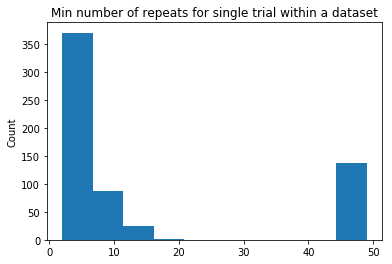

In [51]:
plt.hist(min_repeat);
plt.title('Min number of repeats for single trial within a dataset');
plt.ylabel('Count');

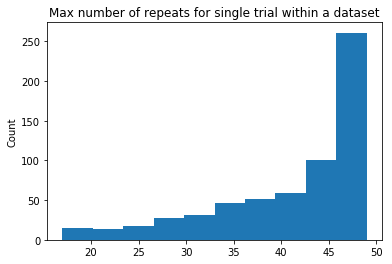

In [52]:
plt.hist(max_repeat);
plt.title('Max number of repeats for single trial within a dataset');
plt.ylabel('Count');

And when repeats occur, they occur quite a lot!

The next step would be to carefully count the number of trials per condition in FIRA, in DOTS and in dotsDB, and analyze the match/mismatch.

In [58]:
def extract_keys(name):
    """
    example names are:
    subj13/probCP0.7/coh100/ansright/CPno/VD300/right/px
    subj13/probCP0.7/coh53/ansright/CPyes/VD300/right/px
    subj11/probCP0.7/coh100/ansleft/CPyes/VD250/left/px
    
    recall 
        (fira['subject'] == 10) & (fira['probCP'] == 0.7) & (fira['coherence'] == 61) \
    & (fira['dirChoice'] == 0) & (fira['reversal'] == 0.2) & (fira['duration'] == .4) & \
    (fira['direction'] == 0)
    """
    items = name.split('/')
    subject = int(items[0][4:])
    probCP = round(float(items[1][6:]), 1)
    coh = int(items[2][3:])
    dir_choice = 1 if items[3][3:] == 'right' else 0
    cp_time = 0.0 if items[4][2:] == 'no' else 0.2
    vd = round(float(items[5][2:]) / 1000, 2)
    init_dir = 0 if items[6] == 'right' else 180
    return subject, probCP, coh, dir_choice, cp_time, vd, init_dir 

Counting trials in three databases (fira + dots + dotsDB) in the cell below takes 20 min.

In [63]:
# By this cell, make sure 'dots', 'fira' and 'dsets' are defined.
# dots and fira are pandas.DataFrame objects, dsets is the dict of counts
# The goal here is to build a dataframe with three columns: dots, fira, h5.
# Each row in this dataframe is a particular dataset in the hdf5 database
# each entry is the trial count for this particular dataset

def count_h5(item_counts):
    """
    :param item_counts: a dict with keys being very long tuples of boolean entries and values being the number
        of occurrences of such trial in the h5py dataset
    """
    total_count = 0
    for i in item_counts:
        if any(i):
            total_count += item_counts[i] 
    return total_count

def count_trials_fira(dset_name, fira_df):
    if dset_name[0] == '/': 
        dset_name = dset_name[1:]
    subj, pcp, coh, choice, cptime, dur, direction = extract_keys(dset_name)
    df = fira_df[
        (fira_df['subject'] == subj) & 
        (fira_df['probCP'] == pcp) & 
        (fira_df['coherence'] == coh) & 
        (fira_df['dirChoice'] == choice) & 
        (fira_df['reversal'] == cptime) & 
        (fira_df['duration'] == dur) & 
        (fira_df['direction'] == direction)
    ]
    return len(df)
    
def count_trials_dots(dset_name, dots_df):
    if dset_name[0] == '/': 
        dset_name = dset_name[1:]
    subj, pcp, coh, choice, cptime, dur, direction = extract_keys(dset_name)
    particular_dset = dots_df[
        (dots_df['subject'] == subj) & 
        (dots_df['probCP'] == pcp) & 
        (dots_df['coherence'] == coh) & 
        (dots_df['dirChoice'] == choice) & 
        (dots_df['reversal'] == cptime) & 
        (dots_df['viewingDuration'] == dur) & 
        (dots_df['initDirection'] == direction)
    ]
    return len(particular_dset['trialIx'].unique())

index_as_list, dicts = [], []
counter = 0
for name in dsets:
    counter += 1
    if (counter % 10) == 0:
        print(counter)
    index_as_list.append(name)
    curr_dict = {}
    h5_count = count_h5(dsets[name][0])
    curr_dict['h5'] = h5_count
    if (counter % 10) == 0:
        print(f'counted h5 {h5_count}')
        
    fira_count = count_trials_fira(name, fira)
    curr_dict['fira'] = fira_count
    if (counter % 10) == 0:
        print(f'counted fira {fira_count}')
        
    dots_count = count_trials_dots(name, dots)
    curr_dict['dots'] = dots_count
    if (counter % 10) == 0:
        print(f'counted dots {dots_count}')
        print()
        
    dicts.append(curr_dict)
counts = pd.DataFrame(dicts, index=index_as_list)

10
counted h5 7
counted fira 7
counted dots 7

20
counted h5 16
counted fira 16
counted dots 16

30
counted h5 20
counted fira 20
counted dots 20

40
counted h5 1
counted fira 1
counted dots 1

50
counted h5 1
counted fira 1
counted dots 1

60
counted h5 6
counted fira 6
counted dots 6

70
counted h5 4
counted fira 4
counted dots 4

80
counted h5 5
counted fira 5
counted dots 5

90
counted h5 6
counted fira 6
counted dots 6

100
counted h5 4
counted fira 4
counted dots 4

110
counted h5 16
counted fira 16
counted dots 16

120
counted h5 1
counted fira 1
counted dots 1

130
counted h5 2
counted fira 2
counted dots 2

140
counted h5 2
counted fira 2
counted dots 2

150
counted h5 30
counted fira 30
counted dots 30

160
counted h5 16
counted fira 16
counted dots 16

170
counted h5 7
counted fira 7
counted dots 7

180
counted h5 4
counted fira 4
counted dots 4

190
counted h5 4
counted fira 4
counted dots 4

200
counted h5 5
counted fira 5
counted dots 5

210
counted h5 3
counted fira 3
co

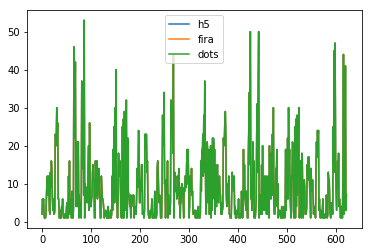

In [64]:
plt.plot(range(len(index_as_list)), counts['h5'], label='h5')
plt.plot(range(len(index_as_list)), counts['fira'], label='fira')
plt.plot(range(len(index_as_list)), counts['dots'], label='dots')
plt.legend()

In [66]:
h5_vs_fira = counts[counts['h5'] != counts['fira']].copy()

In [67]:
any(counts['fira'] != counts['dots'])

False

In [69]:
h5_vs_fira

,dots,fira,h5
subj12/probCP0.3/coh27/ansright/CPno/VD300/right/px,21,21,22


In [80]:
counts.loc[pb_dset_name[1:]]

dots    53
fira    53
h5      53
Name: subj10/probCP0.7/coh61/ansright/CPyes/VD400/right/px, dtype: int64